# Assignment 4 - NLP Disaster Tweets Kaggle Mini Project

## Description

This project is a binary text classification. The goal of this project is to develop a recurring nueral network model that can accurately identify Tweets whose content relates to a real disaster from those that do not. The data is provided by the Kaggle Natural Language Processing with Disaster Tweets Competition and located at https://www.kaggle.com/c/nlp-getting-started/overview.


## Data Summary
The data consists of training and test data.  The train.csv file contains the training data comprised of an id, keyword, location, Tweet text and ground truth labels. There are 7613 rows in the training data.  The test.csv file contains the test data comprised of an id, keyword, location, Tweet text, however it does not include a label. There are 3263 rows in the test data. The sample_submission.csv contains the ids of the test Tweets and sampleground truth labels. The labeles are to be replaced with test results and submitted for assessment of the model.

In [16]:
!pip install pandas emoji
!pip install nltk

In [1]:
#Set Page Width to 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Load Required Resources

import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn import metrics
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import models
from tensorflow.python.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Dropout, Activation, Flatten, Embedding
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Bidirectional
from keras.optimizers import Adam
from tensorflow.keras.layers import*

In [3]:
## Import Data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv ")

print(train_df.head(), '\n')
print(train_df.info(), '\n')
print('Train Shape: ', train_df.shape, '\n')
print(test_df.head(), '\n')
print(test_df.info())
print('Test Shape: ', test_df.shape, '\n')

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None 

Train Shape:  (7613, 5) 

   id 

### EDA

EDA will be performed as follows:

    1. Remove unnecessary columns (keyword and location)
    2. Check for NaNs and Nulls in remaining columns
    3. Understand distributions of data sets
    4. Cleanse test strings
        - Remove Hyperlinks
        - Remove Punctuation
        - Remove Stop Words
        - Convert to all lower case
    
Columns keyword and location are irrelevent to the analysis and therefore removed from the data sets.

**Drop keyword and location**

In [4]:
# drop key and location 

train_df = train_df.drop(['keyword', 'location'], axis=1)
test_df = test_df.drop(['keyword', 'location'], axis=1)

print(train_df.head(), '\n')
print(test_df.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this #earthquake M...       1
1   4             Forest fire near La Ronge Sask. Canada       1
2   5  All residents asked to 'shelter in place' are ...       1
3   6  13,000 people receive #wildfires evacuation or...       1
4   7  Just got sent this photo from Ruby #Alaska as ...       1 

   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about #earthquake is different cities, s...
2   3  there is a forest fire at spot pond, geese are...
3   9           Apocalypse lighting. #Spokane #wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


**Check for Nulls**

In [5]:
#Check for NaNs and Nulls
print('Train id NaNs / Null Count: ', train_df['id'].isna().sum(), '\n')
print('Test id NaNs / Null Count: ', train_df['id'].isna().sum(), '\n')
print('Train text NaNs / Null Count: ', train_df['text'].isna().sum(), '\n')
print('Train text NaNs / Null Count: ', train_df['text'].isna().sum(), '\n')

Train id NaNs / Null Count:  0 

Test id NaNs / Null Count:  0 

Train text NaNs / Null Count:  0 

Train text NaNs / Null Count:  0 



**Label Distributions**

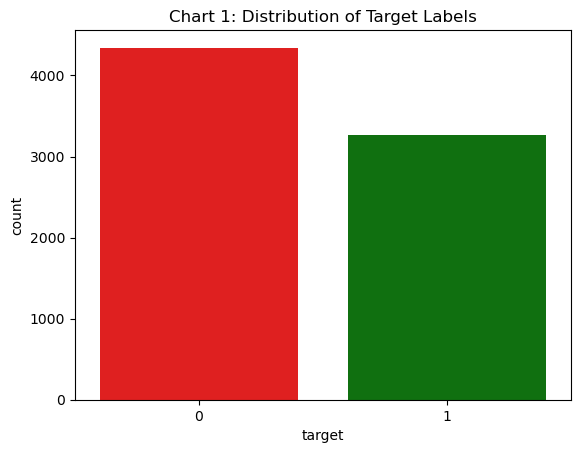

0 Label:  4342
1 Label:  3271


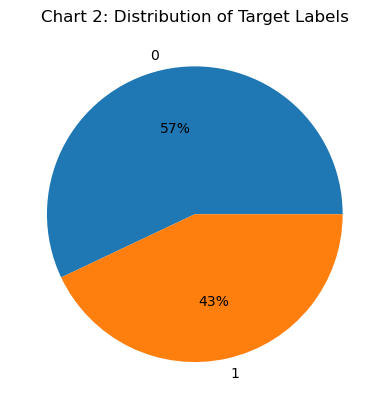

In [6]:
plt.figure()
sns.countplot(data=train_df, x='target', palette=['#ff0000',"#008000"])
plt.title('Chart 1: Distribution of Target Labels')
plt.show()

target_0 = train_df["target"].value_counts()[0]
target_1 = train_df["target"].value_counts()[1]
print('0 Label: ', target_0)
print('1 Label: ', target_1)

plt.figure()
plt.pie([target_0, target_1], labels=[0,1], autopct='%.0f%%')
plt.title('Chart 2: Distribution of Target Labels')
plt.show()


### Cleanse Data

**Remove Hyperlinks**

In [7]:
import re

print('Before')
print(train_df['text'][31])
print(test_df['text'][32])

train_df['text'] = train_df['text'].apply(lambda x:  re.sub(r'https?:\/\/\S+', '', x))
test_df['text'] = test_df['text'].apply(lambda x:  re.sub(r'https?:\/\/\S+', '', x))

print('After')
print(train_df['text'][31])
print(test_df['text'][32])


Before
@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder  Large Re... http://t.co/kKFaSJv6Cj
After
@bbcmtd Wholesale Markets ablaze 
#3: Car Recorder ZeroEdgeå¨ Dual-lens Car Camera Vehicle Traffic/Driving History/Accident Camcorder  Large Re... 


**Remove Punctuation**

In [8]:
train_df['text'] = train_df['text'].str.replace(r'[^\w\s]+', '')
test_df['text'] = test_df['text'].str.replace(r'[^\w\s]+', '')
print(train_df.head(), '/n')
print(test_df.head())

   id                                               text  target
0   1  Our Deeds are the Reason of this earthquake Ma...       1
1   4              Forest fire near La Ronge Sask Canada       1
2   5  All residents asked to shelter in place are be...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  Just got sent this photo from Ruby Alaska as s...       1 /n
   id                                               text
0   0                 Just happened a terrible car crash
1   2  Heard about earthquake is different cities sta...
2   3  there is a forest fire at spot pond geese are ...
3   9              Apocalypse lighting Spokane wildfires
4  11      Typhoon Soudelor kills 28 in China and Taiwan


C:\Users\John.Stronks\AppData\Local\Temp\1\ipykernel_16108\2543514056.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['text'] = train_df['text'].str.replace(r'[^\w\s]+', '')
C:\Users\John.Stronks\AppData\Local\Temp\1\ipykernel_16108\2543514056.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['text'] = test_df['text'].str.replace(r'[^\w\s]+', '')


**Remove Stop Words**

In [9]:
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
  
stop_words = stopwords.words('english')
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print(train_df.head(), '/n')
print(test_df.head())


   id                                               text  target
0   1   Our Deeds Reason earthquake May ALLAH Forgive us       1
1   4              Forest fire near La Ronge Sask Canada       1
2   5  All residents asked shelter place notified off...       1
3   6  13000 people receive wildfires evacuation orde...       1
4   7  Just got sent photo Ruby Alaska smoke wildfire...       1 /n
   id                                               text
0   0                   Just happened terrible car crash
1   2  Heard earthquake different cities stay safe ev...
2   3  forest fire spot pond geese fleeing across str...
3   9              Apocalypse lighting Spokane wildfires
4  11             Typhoon Soudelor kills 28 China Taiwan


**Convert to all lower case**

In [10]:
print('Before')
print(train_df['text'][31])
print(test_df['text'][32])

train_df['text'] = train_df['text'].apply(lambda x:  x.lower())
test_df['text'] = test_df['text'].apply(lambda x:  x.lower())

print('After')
print(train_df['text'][31])
print(test_df['text'][32])

Before
bbcmtd Wholesale Markets ablaze
3 Car Recorder ZeroEdgeå Duallens Car Camera Vehicle TrafficDriving HistoryAccident Camcorder Large Re
After
bbcmtd wholesale markets ablaze
3 car recorder zeroedgeå duallens car camera vehicle trafficdriving historyaccident camcorder large re


### Models

Model Architecture - Long-Short Term Memory (LSTM)

The LSTM model is built around the recurring neural networks (RNN) architecture.  RNNs are neural networks that are capable of analyzing sequential or time series data.  The LSTM is based on a network of gates and feedback loops between nodes and layers.  These gates and feedback loops result in the ability of the network to maintain information over time, where the time frames vary.  The ability to maintain both short- and long-term information allows the network to contextualize the information.  The contextualization characteristic brings the network closer to analyzing information as a human would. 
This makes LSTM models especially adept at analyzing sequential data such a speech or text recognition.  We will use the LSTM model to analyze and categorize texts in this project.  The goal of the LSTM is to properly characterize texts as disaster related or not.  The LSTM model will use training and learned context within the texts to characterize each text. 

The basic LSTM first initializes the text sequence through an encoder.  The encoder transforms the character text strings in to linear arrays based on encoder parameters.  The encoded sequences then pass through various LSTM layers and dense layers to generate a characterization of the text. 

This project will compare two LTSM model architecture, based on accuracy, to see which architecture provides the better performance.  The first model will be a basic LSTM model with and embedding(encoding) layer, a bi-directional LSTM layer, followed by a dense layer with leru activation.  Then pass to a dense layer of one that feeds the characterization layer with sigmoid activation for characterization purposes.
 
The second model will bracket the LSTM layer with a spatial dropout and dropout layer.  The purpose of the addition of the dropout layers is to assess the impact on potential overfitting in the base model.

Transfer learning will not be deployed as to get a better feel for how well the base models learn and characterize from raw inputs.

Various epoch counts were reviewed with 15 being the sweet spot for observing the model differences, while maintaining a reasonable run time.


#### Simple LSTM Model

In [15]:
#Split the training data
x_training_set, x_validation_set, target_train, target_validation= train_test_split(train_df['text'].values, train_df['target'].values, random_state=25, test_size=0.3, shuffle=True)


max_length_text = train_df.text.map(len).max()
print('Maximum Text Length: ', max_length_text)
dict_size = 15000
embedding_size = 64
#Set Up tokenizer

tokenizer = text.Tokenizer(num_words = dict_size)
tokenizer.fit_on_texts(x_training_set)

word_index = tokenizer.word_index

sequence_x_training_set = tokenizer.texts_to_sequences(x_training_set)
sequence_x_validation_set = tokenizer.texts_to_sequences(x_validation_set)
sequence_x_test_set = tokenizer.texts_to_sequences(test_df['text'].values)

sequence_x_training_set_padded = sequence.pad_sequences(sequence_x_training_set, maxlen=max_length_text)
sequence_x_validation_set_padded = sequence.pad_sequences(sequence_x_validation_set, maxlen=max_length_text)
sequence_x_test_set_padded = sequence.pad_sequences(sequence_x_test_set, maxlen=max_length_text)

print('Training Shape: ', sequence_x_training_set_padded.shape)
print('Sample: ', sequence_x_training_set_padded[0])

#Hyperparameter Tuning variables
dropout_rate = .2
recurrent_dropout_rate = .2
num_epochs = 15

model = Sequential()

model.add(Embedding(dict_size, embedding_size, input_length=max_length_text))
model.add(Bidirectional(tf.keras.layers.LSTM(64, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
model.add(Dense(embedding_size, activation='relu'))
model.add(Dense(1))
model.add(Activation('sigmoid'))

input_shape = sequence_x_training_set_padded.shape  
model.build(input_shape) 

model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(sequence_x_training_set_padded, np.asarray(target_train), epochs=num_epochs, validation_data=(sequence_x_training_set_padded, np.asarray(target_train)), verbose=2)

Maximum Text Length:  139
Training Shape:  (5329, 139)
Sample:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 3519 1057 5398  968  969  239  373 3520 2660]
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_19 (ModuleWra (5329, 139, 64)           960000    
__________

#### Complex LSTM Model
Increase the complexity of the previous model by adding a Spatial Dropout layer and a Dropout layer around the LSTM layer.  The addtional layers are intended to help provide increased accurracy while attempting to protect agaist over fitting.

In [16]:
model_complex = Sequential()

model_complex.add(Embedding(dict_size, embedding_size, input_length=max_length_text))
model_complex.add(SpatialDropout1D(0.5))  ## addtional layer
model_complex.add(Bidirectional(tf.keras.layers.LSTM(64, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
model_complex.add(Dropout(0.2)) ## addtional layer
model_complex.add(Dense(embedding_size, activation='relu'))
model_complex.add(Dense(1))
model_complex.add(Activation('sigmoid'))

input_shape = sequence_x_training_set_padded.shape  
model_complex.build(input_shape) 

model_complex.summary()

model_complex.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

comlex_history = model_complex.fit(sequence_x_training_set_padded, np.asarray(target_train), epochs=num_epochs, validation_data=(sequence_x_training_set_padded, np.asarray(target_train)), verbose=2)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_24 (ModuleWra (5329, 139, 64)           960000    
_________________________________________________________________
module_wrapper_25 (ModuleWra (5329, 139, 64)           0         
_________________________________________________________________
module_wrapper_26 (ModuleWra (5329, 128)               66048     
_________________________________________________________________
module_wrapper_27 (ModuleWra (5329, 128)               0         
_________________________________________________________________
module_wrapper_28 (ModuleWra (5329, 64)                8256      
_________________________________________________________________
module_wrapper_29 (ModuleWra (5329, 1)                 65        
_________________________________________________________________
module_wrapper_30 (ModuleWra (5329, 1)                

### Model Comparison

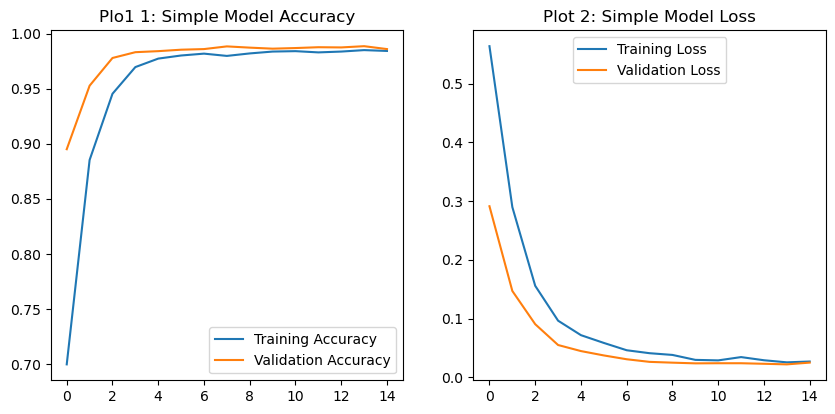

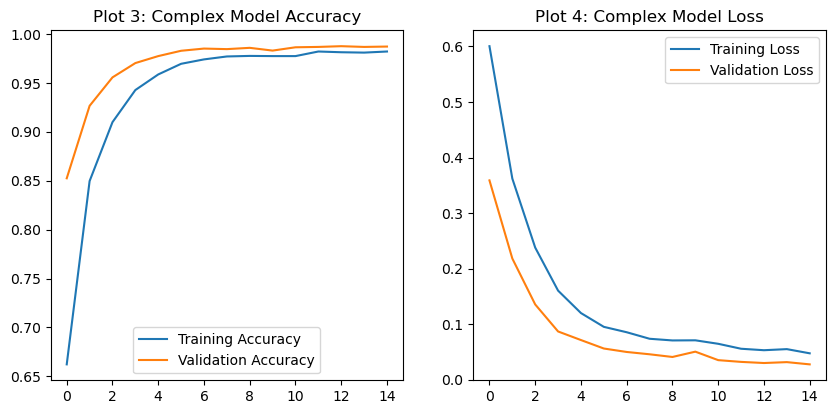

In [20]:
#Simple Model
model_accuracy = history.history['accuracy']
model_val_acc = history.history['val_accuracy']
model_loss = history.history['loss']
model_val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, model_accuracy, label='Training Accuracy')
plt.plot(epochs_range, model_val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Plo1 1: Simple Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, model_loss, label='Training Loss')
plt.plot(epochs_range, model_val_loss, label='Validation Loss')
plt.legend(loc='upper center')
plt.title('Plot 2: Simple Model Loss')
plt.show()

#complex Model
model_complex_accuracy = comlex_history.history['accuracy']
model_complex_val_acc = comlex_history.history['val_accuracy']
model_complex_loss = comlex_history.history['loss']
model_complex_val_loss = comlex_history.history['val_loss']


plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, model_complex_accuracy, label='Training Accuracy')
plt.plot(epochs_range, model_complex_val_acc, label='Validation Accuracy')
plt.legend(loc='lower center')
plt.title('Plot 3: Complex Model Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, model_complex_loss, label='Training Loss')
plt.plot(epochs_range, model_complex_val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Plot 4: Complex Model Loss')
plt.show()

**Table 1: Model Complexity vs Accuracy***

|Model|Accuracy|Validation Accuracy|
|:----|:--------:|:--------:|
|Simple|.9842|.9889|
|Complex|.9722|.9872|


Plots 1 thru 4 provide a view of the training accuracy and loss metrics between the simple and complex LSTM models.  Based on the charts and table, increasing the complexity by adding the additional dropout layers negatively impacted the accuracy.  The more complex model showed ~1.5% degradation.  

However, when looking closely at the plots at around the 8th epoch, the simple model’s accuracy and los begin to show signs of slight cavitation.  Additionally, by the 15th epoch the loss and accuracy of the base model are essentially identical.  

Whereas the complex model’s accuracy and loss continue to converge with the gap between the two eventually leveling out around the 10th epoch.   
Taking these two observations together it appears that the simple model is showing signs of overfitting while the complex model does not.  The implication being that adding the additional dropout layers aided in protecting the complex model from overfitting. 



### Hyperparameter Tuning

Number of Epochs will be varied and the impact on accruacy assessed.

In [58]:
epoch_count = [5, 10, 15, 20]
history = []

for e in epoch_count:

    num_epochs = e
    
    tune_model = Sequential()

    tune_model.add(Embedding(dict_size, embedding_size, input_length=max_length_text))
    tune_model.add(Bidirectional(tf.keras.layers.LSTM(64, dropout = dropout_rate, recurrent_dropout=recurrent_dropout_rate)))
    tune_model.add(Dense(embedding_size, activation='relu'))
    tune_model.add(Dense(1))
    tune_model.add(Activation('sigmoid'))

    input_shape = sequence_x_training_set_padded.shape  
    tune_model.build(input_shape) 

    tune_model.summary()
    
    tune_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    tune_history = tune_model.fit(sequence_x_training_set_padded, np.asarray(target_train), epochs=num_epochs, validation_data=(sequence_x_training_set_padded, np.asarray(target_train)), verbose=2)

    print('Eochs: ', e)
    print('History: ', tune_history.history)
    history.append(tune_history.history)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_132 (ModuleWr (5329, 139, 64)           960000    
_________________________________________________________________
module_wrapper_133 (ModuleWr (5329, 128)               66048     
_________________________________________________________________
module_wrapper_134 (ModuleWr (5329, 64)                8256      
_________________________________________________________________
module_wrapper_135 (ModuleWr (5329, 1)                 65        
_________________________________________________________________
module_wrapper_136 (ModuleWr (5329, 1)                 0         
Total params: 1,034,369
Trainable params: 1,034,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
167/167 - 34s - loss: 0.5614 - accuracy: 0.7013 - val_loss: 0.3061 - val_accuracy: 0.8790
Epoch 2/5

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_147 (ModuleWr (5329, 139, 64)           960000    
_________________________________________________________________
module_wrapper_148 (ModuleWr (5329, 128)               66048     
_________________________________________________________________
module_wrapper_149 (ModuleWr (5329, 64)                8256      
_________________________________________________________________
module_wrapper_150 (ModuleWr (5329, 1)                 65        
_________________________________________________________________
module_wrapper_151 (ModuleWr (5329, 1)                 0         
Total params: 1,034,369
Trainable params: 1,034,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
167/167 - 54s - loss: 0.5591 - accuracy: 0.7050 - val_loss: 0.3000 - val_accuracy: 0.8801
Epoch 2/

### Hyperparameter Tuning Results

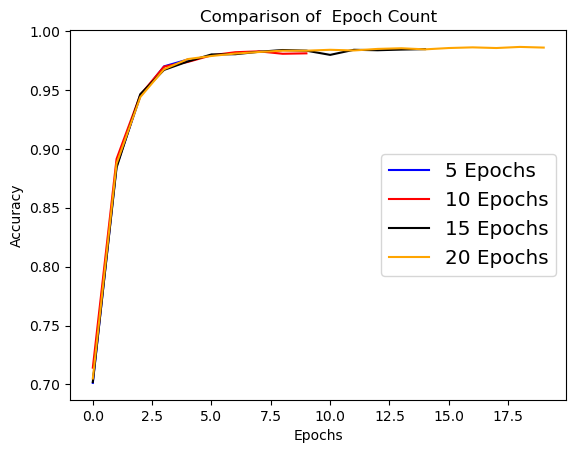

In [68]:

e1 = [11, 10, 12, 14, 16, 19, 17, 14, 18, 17]
x_e1 = range(0,5)
x_e2 = range(0,10)
x_e3 = range(0,15)
x_e4 = range(0,20)

fig, ax = plt.subplots()
ax.plot(x_e1, history[0]['accuracy'], label='5 Epochs', color='blue')
ax.plot(x_e2, history[1]['accuracy'], label='10 Epochs', color = 'red')
ax.plot(x_e3, history[2]['accuracy'], label='15 Epochs', color='black')
ax.plot(x_e4, history[3]['accuracy'], label='20 Epochs', color = 'orange')

legend = ax.legend(loc='center right', fontsize='x-large')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Plot 5: Comparison of  Epoch Count')
plt.show()

#### Accuracy Comparison
**Table 2: Epoch COunt vs Accuracy***

|Epoch Count|Accuracy|Validation Accuracy|
|:----|:--------:|:--------:|
|5|.9758|.9844|
|10|.9810|.9865|
|15|.9846|.9884|
|20|.9859|.9882|

As can be seen in Plot 5 and Table 2, increased epoch count provided a marginal impact to accuracy.  Increasing the epoch count from 5 to 20 realized a 1% increase in accuracy from 97.58% to 98.59% respectively.  Plot 5 also shows that the accuracy rate was not impacted by the number of epochs, all 4 cases climbed in accuracy at essentiall the same rate.

GIven the margin improvement in test and validation accuracy, going with the 10-15 epochs is the best tradeoff given computational resources and model accuracy.

In [21]:
#Get test set predictions
target_test = model.predict(sequence_x_test_set_padded, verbose = 1)
target_test
print('Test Shape: ', target_test.shape, '\n')

102/102 [==============================] - 4s 19ms/step
Test Shape:  (3263, 1) 



In [22]:
#Generate submission file
test_submission = np.where(target_test <= 0.5, 0, 1)

final_submission = np.transpose(test_submission)[0]
final_submission = pd.DataFrame()
final_submission['id'] = test_df['id']
final_submission['target'] = test_submission
print(final_submission.head())

final_submission.to_csv('submission.csv', index=False)

   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


### Conclusion

**Model Comparison**

Over 15 epochs, comparisons of the simple and complex models showed marginal accuracy and loss differences.  The simple model performed slightly better with its final accuracy 1.2% better at 98.42%, then the complex model at 97.22%.

However as outlined above, the simple model began to show signs of overfitting at around the 10th epoch, while the complex model did not.  Based on the analysis and discussion above, the conclusion is that the addition of the drop out layers to the complex model proved to be beneficial.  Given the marginal difference in performance and the overfitting protection on the complex model, the complex model is deemed the better of the two.


**Hyper paramter Tuning**

Hyper parameter tuning, varying the number of epochs, provided some insight into how epoch count impacted the model’s performance.  The total difference in performance across the 4 different epoch counts resulted in a maximum accuracy difference of 1.01% between 5 and 20 epochs.  The middle two epoch counts (10 and15) resulted in only a .36% difference in accuracy.
When considering the essentially identical accuracy rate climb between models and the minimal accuracy differences, 10 epochs is deemed more than sufficient in getting good accuracy, while balancing computation effort.


**Test Submission**

Best model submission was 78.85%. Based on the much better performance of the training and validation models one can conclude that overfitting existed or that the test data was reasonably different from the training data set.  Most likely a combination of both.


### References

Remove Stop Words from Text in DataFrame Column, https://www.datasnips.com/58/remove-stop-words-from-text-in-dataframe-column/

How to Remove URLs from Text in Python, https://bobbyhadz.com/blog/python-remove-url-from-text